# Linear Regression 

Linear regression is a statistical method used to model the relationship between a dependent variable (often denoted as "y") and one or more independent variables (often denoted as "x"). The basic idea of linear regression is to find the straight line that best fits the data points in a scatter plot.

The most common form of linear regression is simple linear regression, which models the relationship between two variables:

$y = mx + b$

where y is the dependent variable, x is the independent variable, m is the slope, and b is the intercept. 

Given a set of input data ($\{x_i, y_i\}$), the goal of linear regression is to find the values of m and b that best fit the data


The values of m and b are chosen to minimize the **"sum of squared errors" (SSE) $(\sum (y - \hat{y})^2)$.**

**Taking the partial derivatives with respect to m and b, set them equal to 0, and solve for m and b**, we get:

m = sum((x - x_mean) * (y - y_mean)) / sum((x - x_mean)^2)   
b =  y_mean - m * x_mean


Multiple linear regression is a more general form of linear regression that models the relationship between multiple independent variables and one dependent variable. The formula for the best-fit hyperplane in multiple linear regression is:

$y = w_0 + w_1.x_1 + w_2.x_2 + ... + w_n.x_n = X^T. W$

### Simple linear regression 
Here is a basic implementation of simple linear regression in Python using the least squares method:

In [1]:
import numpy as np

class LinearRegression:
    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y):
        n = len(X)
        x_mean = np.mean(X)
        y_mean = np.mean(y)
        numerator = 0
        denominator = 0
        for i in range(n):
            numerator += (X[i] - x_mean) * (y[i] - y_mean)
            denominator += (X[i] - x_mean) ** 2
        self.slope = numerator / denominator
        self.intercept = y_mean - self.slope * x_mean

    def predict(self, X):
        y_pred = []
        for x in X:
            y_pred.append(self.slope * x + self.intercept)
        return y_pred


In [2]:
X = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 5, 4, 5])
lr = LinearRegression()
lr.fit(X, y)
print(lr.slope)  # Output: 0.6
print(lr.intercept)  # Output: 2.2
y_pred = lr.predict(X)
print(y_pred)  # Output: [2.8, 3.4, 4.0, 4.6, 5.2]


# print(f"The value of x is {x:.2f}")


0.6
2.2
[2.8000000000000003, 3.4000000000000004, 4.0, 4.6, 5.2]


### Normal Equation

$Y = X.W$  

take partial derivatives of cost function (MSE) with respect to all coefficient w, set them to 0, we get optimal W as:

$W = (X^T.X)^{-1}X^T.Y $

matrix $X^T.X$ is not invertible on edge cases that if m<n or if some features are redundant.

**scale well by rows $O(m)$ but scale not well by columns $O(n^2.4)$ to $O(n^3)$** m is number of instance and n is number of features

<span style="color:red"> **remember to add bias term to X** </span>

In [7]:
import numpy as np

class LinearRegression:
    def __init__(self):
        self.W = None

    def fit(self, X, y):
        '''
        X: n x d 
        '''
        # Add bias term to X -> [1 X]
        n = X.shape[0]
        X = np.hstack([np.ones((n, 1)), X])
        self.W = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X):
        n = X.shape[0]
        X = np.hstack([np.ones((n, 1)), X])
        return X @ self.W
    


In [10]:
# Create example input data
X = np.array([[2, 2], [4, 5], [7, 8]])
y = np.array([9, 17, 26])

# Fit linear regression model
lr = LinearRegression()
lr.fit(X, y)
print(lr.W) # [3. 1. 2.]

# Make predictions on new data
X_new = np.array([[10, 11], [13, 14]])
y_pred = lr.predict(X_new)
print(y_pred)  # Output: [43. 55.]

[1. 2. 3.]
[35. 44.]


### SVD decomposition 

More efficient than Normal Equation and it handels edge case better.SVD always work whereas Normal Equation is not. But same as Normal Equation, SVD scales well by rows but not by columns.

### Improvements 
here are some improvements to the simple linear regression implementation to make it more robust:

1. Add input **validation**: Add input validation to check that the input arrays X and y have the same length and are not empty.

2. Use NumPy broadcasting: Instead of looping through the data to calculate the numerator and denominator, we can use NumPy broadcasting to perform the calculations in a vectorized way. This will make the code faster and more efficient.

3. Add **regularization**: Regularization can help prevent overfitting by adding a penalty term to the cost function. One common regularization technique is L2 (Ridge) regularization, which adds the sum of squares of the coefficients to the cost function. This can be easily added to the code by adding a regularization parameter to the constructor. When there are many useless features, you should prefer L1/Lasso or Elastic Net regularization over L2/Ridge, since L1 tend to reduce the weight of useless features to zero. **Elastic Net is preferred over L2/Lasso since L2 can behave erratically when the number of features is less than the number of instances or when some features are strongly correlated**. <span style="color:red">**Do not regularize bias term.**</span>

   **L2 in cost function： regularization_ratio * $\sum(W^2)$**

5. Use **gradient descent**: For large datasets, calculating the inverse of the matrix in the normal equation can be computationally expensive. To overcome this, we can use gradient descent to minimize the cost function. This can be implemented by adding a method that updates the coefficients iteratively using the gradient descent algorithm.
6. **Early Stopping**: an efficient regularization technique that prevent overfit. It stops model training when validation error increases.

Here's the updated code that incorporates these improvements:

### Batch gradient descent with L2 regularization

Calculate the partial derivatives of the cost function（MSE） with regards to each coefficient using all training samples.

partial derivatives of the cost function（MSE): <span style="color:red"> $2/m*X^T.(X.W-Y) $ </span>

Scales well by columns but not well by rows

Can stuck at local minima if the cost function is not convex (linear regression and logistic regress cost functions are convex)

<span style="color:red"> when learning rate is too high, it will diverge (jumping all over the place and become further and further away from the solution) </span>

In [40]:
import numpy as np


class LinearRegressionGD:
    def __init__(self, regul=0):
        self.regul = regul
        self.W = None

    def fit(self, X, y, lr=0.01, num_iter=1000):
        # Input validation
        if len(X) != len(y) or len(X) == 0:
            raise ValueError("X and y must have the same length and cannot be empty")
        
        # Add bias term to X -> [1 X]
        X = np.hstack([np.ones((len(X), 1)), X])

        # Initialize W to zeros
        self.W = np.zeros(X.shape[1])

        # Use gradient descent to minimize cost function
        for i in range(num_iter):
            # number of rows
            m = len(X)
            
            # Calculate predicted values
            y_pred = np.dot(X, self.W)

            # # Calculate cost function
            # cost = np.sum((y_pred - y) ** 2)/m + self.regul * np.sum(self.W[1:] ** 2)

            # Calculate gradients
            gradients = (2/m) * X.T.dot(y_pred - y) + np.r_[[0],2 * self.regul * self.W[1:]]

            # Update W
            self.W = self.W - lr * gradients

            # if (i % 1000 == 0 ): print(cost)

    def predict(self, X):
        # Add bias term to X
        X = np.hstack([np.ones((len(X), 1)), X])

        # Calculate predicted values
        y_pred = np.dot(X, self.W)
        return y_pred

In [41]:
X = np.array([[1, 2, 3, 4, 5]]).T
y = np.array([2, 4, 5, 4, 5])
lr = LinearRegressionGD(regul=0.1)
lr.fit(X, y, lr=0.01, num_iter=10000)
print(lr.W)  # Output: [ 1.99964292  0.65345474 ]
y_pred = lr.predict(X)
print(y_pred)  # # Output: [2.65309766, 3.3065524, 3.96000714, 4.61346188, 5.26691662]


[2.28571429 0.57142857]
[2.85714286 3.42857143 4.         4.57142857 5.14285714]


### Stochastic Gradient Descent with learning schedule and L2 regularization

Computes gradients based on a single instance because Gradient Descent does not scale well by rows.

Helps escape from local minima but bad at converging at the global minimum. Solution is learning schedule to gradually decrease learning rate.

learning schedule: $\lambda = 1/(t+\lambda_0), \lambda_0=50$ 

Iterate by rounds of m(#rows) iterations. Each round is called an epoch. **Bootstrap converges faster than exhausting all instances at each epoch.**

In [33]:
class LinearRegressionSGD:
    def __init__(self, regul, n_iter, t0=1, t1=50):
        self.W = None
        self.regul = regul
        self.n_iter = n_iter
        self.t0 = t0
        self.t1=t1
        
    def learning_schedule(self, t):
        return self.t0/(t+self.t1)
        
    def fit(self, X, y):
        if len(X)!=len(y) or len(X)==0:
            raise ValueError("X and y must have the same length and cannot be empty")
            
        m = len(X)
           
        # X -> [1,X]
        X = np.hstack([np.zeros((len(X),1)), X])
        
        # initialize W
        self.W = np.zeros(X.shape[1])

        # iterate by epoch to gradient decent
        for epoch in range(self.n_iter):
            for i in range(m):
                random_index = np.random.randint(m)
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]
                yi_pred = xi.dot(self.W)
                gradients = 2 * xi.T.dot(yi_pred - yi) + 2 * self.regul * self.W
                lr = self.learning_schedule(epoch*m+i)
                self.W = self.W - lr * gradients

    def predict(self, X):
        X = np.hstack([np.zeros((len(X),1)),X])
        y = X.dot(self.W)
        return y
            

In [34]:
X = np.array([[1, 2, 3, 4, 5]]).T
y = np.array([2, 4, 5, 4, 5])
lr = LinearRegressionSGD(regul=0.1, n_iter=5000)
lr.fit(X, y)
print(lr.W)  # Output: [ 1.99964292  0.65345474 ]
y_pred = lr.predict(X)
print(y_pred)  # # Output: [2.65309766, 3.3065524, 3.96000714, 4.61346188, 5.26691662]

[0.         1.18409764]
[1.18409764 2.36819529 3.55229293 4.73639058 5.92048822]


### Mini-batch Gradient Descent

Computes the gradients on small random sets of instances. 

Advantage is performance boost from hardware optimization of matrix operations, especially when using GPUs.

**Tradeoff between trapped in local minima and converging at global minimum. number of batch size is small will help walk out of local minima. learning schedule will help ending up at global minimum**


## Visualize 

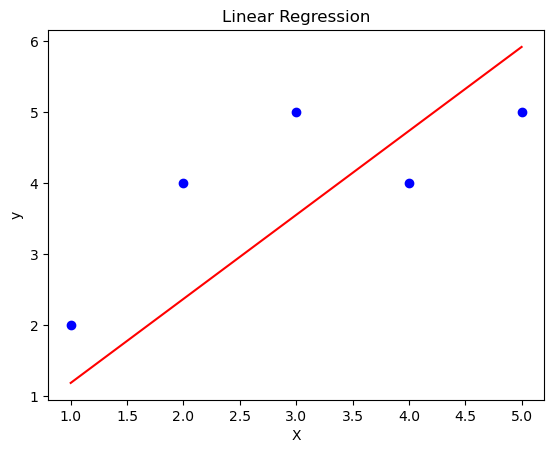

In [36]:
import matplotlib.pyplot as plt 

# Plot the data and the linear regression line
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.show()

## sklearn